#### Сравнение времени регистрации транзакций при подаче через торговый терминал QUIK
Цель: сравнить время регистрации тарнзакций на Московской бирже, отправляемых через торговый терминал QUIK используя три способа. 

1. Подключение торговым терминалом QUIK из внутренней сети напрямую к серверу QUIK
2. Подключение торговым терминалом QUIK из внутренней сети через сервер доступа QUIK
3. Подключение торговым терминалом QUIK из интернета через сервер доступа QUIK

Замер времени регистрации транзакций осуществлялся используя скрипты, написанные на lua.
Скрипты находятся в репозитории в папке lua. 


In [1]:
# импортируем необходимые модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from datetime import date, timedelta
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.offline import plot
np.random.seed(798)
sns.set()

In [2]:
'''
df_server: датафрейм для кейса 1
df_as: датафрейм для кейса 2
df_internet: датафрейм для кейса 3
'''
df_server=pd.read_csv('.\\stat\\server.txt',sep=';',header=0)
df_as=pd.read_csv('.\\stat\\access_server.txt',sep=';',header=0)
df_internet=pd.read_csv('.\\stat\\internet.txt',sep=';',header=0)

In [3]:
# смотрим структуру датафрейма
print(df_server.info())
'''
описание полей
type: тип транзакции 
    send_order-отправить транзакцию "заявка на покупку" на биржу
    kill_order: отправить транзакцию "снять заявку" на биржу
trans_id: уникальный номер транзакции
local_time: время выставления транзакции
order_num: номер заявки на регистрацию на бирже
order_start_time: время до отправки транзакции
order_stop_time: время после ответа об успешной регистрации заявки
delta_time: разница между order_start_time и order_stop_time по модулю
Stock: рынок, по которому отправлялись транзакции
date: дата отправки транзакций
'''

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              400 non-null    object 
 1   trans_id          400 non-null    int64  
 2   local_time        400 non-null    int64  
 3   order_num         400 non-null    int64  
 4   order_start_time  400 non-null    float64
 5   order_stop_time   400 non-null    float64
 6   delta_time        400 non-null    float64
 7   Stock             400 non-null    object 
 8   date              400 non-null    int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 28.2+ KB
None


'\nописание полей\ntype: тип транзакции \n    send_order-отправить транзакцию "заявка на покупку" на биржу\n    kill_order: отправить транзакцию "снять заявку" на биржу\ntrans_id: уникальный номер транзакции\nlocal_time: время выставления транзакции\norder_num: номер заявки на регистрацию на бирже\norder_start_time: время до отправки транзакции\norder_stop_time: время после ответа об успешной регистрации заявки\ndelta_time: разница между order_start_time и order_stop_time по модулю\nStock: рынок, по которому отправлялись транзакции\ndate: дата отправки транзакций\n'

In [4]:
# функция для подготовки данных к анализу
def f_df_transform(df):
    df[['date','local_time']]=df[['date','local_time']].astype(str)
    df['len_local_time']=df.local_time.map(len)
    df.loc[df['len_local_time']==5,'local_time']='0'+df['local_time']
    df.loc[df['len_local_time']==4,'local_time']='00'+df['local_time']
    df.loc[df['len_local_time']==3,'local_time']='000'+df['local_time']
    df.loc[df['len_local_time']==2,'local_time']='0000'+df['local_time']
    df.loc[df['len_local_time']==1,'local_time']='00000'+df['local_time']

    df['date_time']=df['date']+' '+df['local_time']
    df['date_time']=pd.to_datetime(df['date_time'],format='%Y%m%d %H%M%S')
    df['seconds']=df.delta_time
    df=df.set_index('date_time')
    df['date_time']=df.index
    df.index.name=None
    df=df.sort_values(by=['date_time'])
    df=df.drop(['Stock','trans_id','local_time','len_local_time','delta_time','date','order_start_time','order_stop_time','date_time'],axis=1)
    return df
#------------------------------------------------------------------------------


In [5]:
# готовим данные к анализу используя функцию f_df_transform()
df_server=f_df_transform(df_server)
df_as=f_df_transform(df_as)
df_internet=f_df_transform(df_internet)

In [6]:
''' смотим на примере датафрейма df_server что получилось
название поля delta_time заменено на поле seconds
seconds: время полного цикла обработки транзакции '''
print(df_server.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 400 entries, 2022-04-12 12:06:01 to 2022-04-12 12:07:02
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   type       400 non-null    object 
 1   order_num  400 non-null    int64  
 2   seconds    400 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 12.5+ KB
None


In [7]:
# используя метод describe() смотрим, что получилось
print(f'\nServer transaction time result in seconds:\n {df_server.describe().seconds}')
print(f'\nAccess server transaction time result in seconds:\n {df_as.describe().seconds}')
print(f'\nInternet transaction time result in seconds:\n {df_internet.describe().seconds}')


Server transaction time result in seconds:
 count    400.000000
mean       0.019820
std        0.011033
min        0.007000
25%        0.012000
50%        0.015000
75%        0.024000
max        0.097000
Name: seconds, dtype: float64

Access server transaction time result in seconds:
 count    400.000000
mean       0.040160
std        0.020123
min        0.009000
25%        0.030000
50%        0.034000
75%        0.050000
max        0.119000
Name: seconds, dtype: float64

Internet transaction time result in seconds:
 count    398.000000
mean       0.077693
std        0.025429
min        0.036000
25%        0.058000
50%        0.077000
75%        0.091000
max        0.255000
Name: seconds, dtype: float64


In [8]:
# добавляем новое поле с категорией
'''
server: соответствует кейсу 1
as: соответствует кейсу 2
internet: соответствует кейсу 3
'''
df_server['id']='server'
df_as['id']='as'
df_internet['id']='internet'

# объединяем все данные в один датафрейм
df=pd.concat([df_server,df_as,df_internet])

C:\Program Files\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Program Files\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

74.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Program Files\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

63.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Program Files\Python310\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

46.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



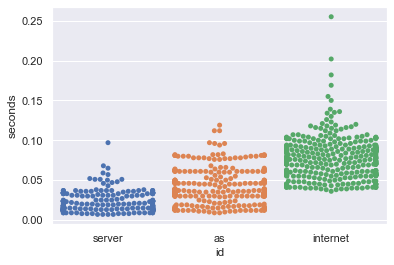

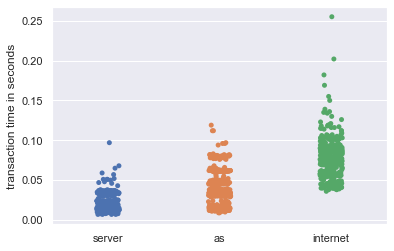

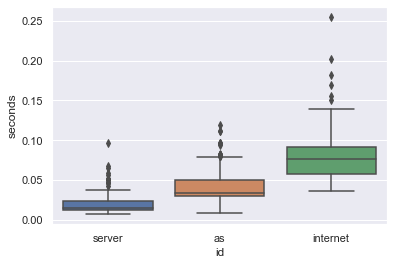

In [9]:
# посторим график, на котором по оси y - время регистрации транзакции, а на оси x - категория из условаия 3ех кейсов
sns.set()

#_=sns.swarmplot(df.id,df.seconds)
_=sns.stripplot(data=df, x='id',y='seconds')
_=plt.xlabel('')
_=plt.ylabel('transaction time in seconds')
plt.show()

_=sns.boxplot(data=df,x=df.id,y=df.seconds)
plt.show()

Рассмотрев графики видим, что время регистрации транзакций через разные компоненты отличается.
Рассматриваемая велечина seconds является количественной.
Напишем функцию для построения эмпирической кумулятивной функции распределения исходя из наших данных.

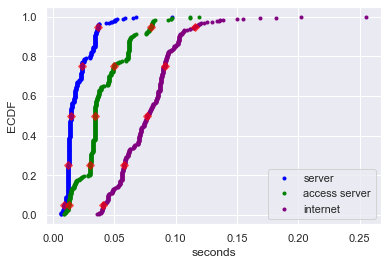

In [10]:
# функция для подготовки данных для построения графика кумулятивной функции распределения
def ecdf(data):
    n=len(data)
    x=np.sort(data)
    y=np.arange(1,n+1)/n
    return x,y

# создаем массивы с данными
serv_seconds=df[df.id=='server'].seconds
as_seconds=df[df.id=='as'].seconds
int_seconds=df[df.id=='internet'].seconds

# используя функию ecdf() получаем данные для построения графиков кумулятивных функций распределения
x_s,y_s=ecdf(serv_seconds)
x_as,y_as=ecdf(as_seconds)
x_int,y_int=ecdf(int_seconds)

# найдем процентили для каждого из массивов
percentiles=np.array([5,25,50,75,95])
ptiles_s=np.percentile(serv_seconds,percentiles)
ptiles_as=np.percentile(as_seconds,percentiles)
ptiles_int=np.percentile(int_seconds,percentiles)

# построим график эмпирической кумулятивной функции и отметим процентили для каждого из кейсов
_=plt.plot(x_s,y_s,marker='.',linestyle='none',color='blue')
_=plt.plot(x_as,y_as,marker='.',linestyle='none',color='green')
_=plt.plot(x_int,y_int,marker='.',linestyle='none',color='purple')
_=plt.plot(ptiles_s,percentiles/100,marker='D',color='red',linestyle='none',alpha=0.6)
_=plt.plot(ptiles_as,percentiles/100,marker='D',color='red',linestyle='none',alpha=0.6)
_=plt.plot(ptiles_int,percentiles/100,marker='D',color='red',linestyle='none',alpha=0.6)
_=plt.legend(('server','access server','internet'),loc='lower right')
_=plt.xlabel('seconds')
_=plt.ylabel('ECDF')

In [11]:
print(f'50% регистрации всех транзакций для кейса 1 (график server) составляет по времени менее: {ptiles_s[2]} секунды')
print(f'50% регистрации всех транзакций для кейса 2 (график access server) составляет по времени менее: {ptiles_as[2]} секунды')
print(f'50% регистрации всех транзакций для кейса 3 (график internet) составляет по времени менее: {ptiles_int[2]} секунды')

50% регистрации всех транзакций для кейса 1 (график server) составляет по времени менее: 0.01500000001397 секунды
50% регистрации всех транзакций для кейса 2 (график access server) составляет по времени менее: 0.0340000000142025 секунды
50% регистрации всех транзакций для кейса 3 (график internet) составляет по времени менее: 0.077000000000226 секунды


Построим график функции плотности вероятности для среднего значения времени регистрации транзакции mean().
Для этого напишем две функции bootstrap_replicate() и draw_bs_reps()

In [12]:
''' функция bootstrap_replicate смоделирует рандомную выборку значений массива data 
 и вернет результат переданной в параметры функции func '''
def bootstrap_replicate(data,func):
    bs_sample=np.random.choice(data,len(data))
    return func(bs_sample)

# пример расчета mean() для массива serv_seconds эмпирического и смоделированного
print(f'Эмперическое mean() времени регистрации транзакций df_server: {np.mean(serv_seconds)} seconds')
print(f'Смоделированное mean() времени регистрации транзакций df_server: {bootstrap_replicate(serv_seconds,np.mean)} seconds')

Эмперическое mean() времени регистрации транзакций df_server: 0.019820000000472654 seconds
Смоделированное mean() времени регистрации транзакций df_server: 0.02037749999901279 seconds


In [13]:
''' функция draw_bs_reps смоделирует массив дынных нужной статистической величины (например mean() или std()) 
 на основании функции bootstrap_replicate() равное size количеству раз '''
def draw_bs_reps(data,func,size=1):
    bs_replicates=np.empty(size)
    for i in range(size):
        bs_replicates[i]=bootstrap_replicate(data,func)
    return bs_replicates


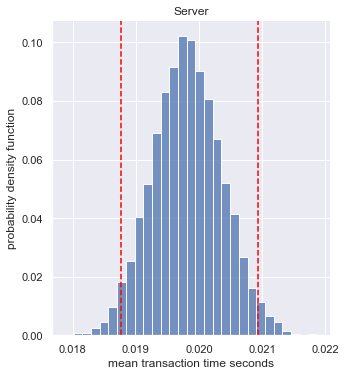

Server 95% доверительный интервал среднего в секундах: [0.01877   0.0209325] 
Server стандартная ошибка среднего эмпирических данных: 0.0005509482734900955 
Server стандартная ошибка среднего смоделированного массива: 0.0005461845562805818 


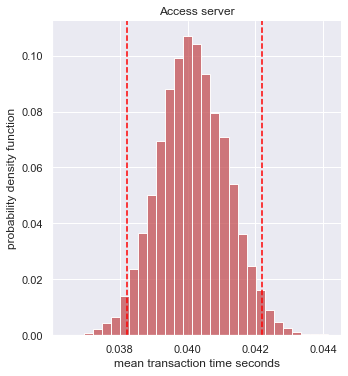

Access server 95% доверительный интервал среднего в секундах: [0.03820744 0.04218756] 
Access server стандартная ошибка среднего эмпирических данных: 0.0010049121853226187 
Access server стандартная ошибка среднего смоделированного массива: 0.0010050621825257171 


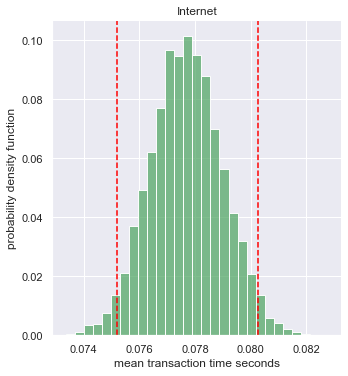

Internet 95% доверительный интервал среднего в секундах: [0.07518574 0.08027387] 
Internet стандартная ошибка среднего эмпирических данных: 0.001273045442912571 
Internet стандартная ошибка среднего смоделированного массива: 0.0012865330910197836 


In [14]:
''' смоделируем массив данных среднего времени регистрации транзакций mean() для каждого из кейсов
 для этого используем 3 массива serv_seconds, as_seconds и int_seconds '''
serv_bs_replicates=draw_bs_reps(serv_seconds,func=np.mean,size=10000)
as_bs_replicates=draw_bs_reps(as_seconds,func=np.mean,size=10000)
int_bs_replicates=draw_bs_reps(int_seconds,func=np.mean,size=10000)
# найдем 95% доверительный интервал для каждого из кейсов
serv_ptiles_bs_replicates=np.percentile(serv_bs_replicates,np.array([2.5,97.7]))
as_ptiles_bs_replicates=np.percentile(as_bs_replicates,np.array([2.5,97.7]))
internet_ptiles_bs_replicates=np.percentile(int_bs_replicates,np.array([2.5,97.7]))


''' построим график функции плотности вероятности для среднего значения времени регистрации транзакции mean()
и добавим 95% доверительный интервал на график
также сравним стандартную ошибку среднего эмпирических данных и стандартное отклонение среднего, 
полученного из смоделированных массивов
 '''
# стандартная ошибка среднего эмпирических данных
serv_sem_emp=np.std(serv_seconds)/np.sqrt(len(serv_seconds))
# стандартная ошибка среднего смоделированного массива среднего
serv_sem_repl=np.std(serv_bs_replicates)
bin_count=int(1+3.122*np.log(len(serv_bs_replicates))) # рассчитаем кол-во столбцов гистограммы по правилу Стерджеса
sns.displot(serv_bs_replicates,stat='probability',bins=bin_count)
_=plt.axvline(x=serv_ptiles_bs_replicates[0],ymin=0,ymax=1,color='red',linestyle='--')
_=plt.axvline(x=serv_ptiles_bs_replicates[1],ymin=0,ymax=1,color='red',linestyle='--')
_=plt.xlabel("mean transaction time seconds")
_=plt.ylabel("probability density function")
_=plt.title('Server')
plt.show()
print(f"Server 95% доверительный интервал среднего в секундах: {serv_ptiles_bs_replicates} ")
print(f"Server стандартная ошибка среднего эмпирических данных: {np.std(serv_seconds)/np.sqrt(len(serv_seconds))} ")
print(f"Server стандартная ошибка среднего смоделированного массива: {np.std(serv_bs_replicates)} ")
sns.displot(as_bs_replicates,color='r',stat='probability',bins=bin_count)
_=plt.axvline(x=as_ptiles_bs_replicates[0],ymin=0,ymax=1,color='red',linestyle='--')
_=plt.axvline(x=as_ptiles_bs_replicates[1],ymin=0,ymax=1,color='red',linestyle='--')
_=plt.xlabel("mean transaction time seconds")
_=plt.ylabel("probability density function")
_=plt.title('Access server')
plt.show()
print(f"Access server 95% доверительный интервал среднего в секундах: {as_ptiles_bs_replicates} ")
print(f"Access server стандартная ошибка среднего эмпирических данных: {np.std(as_seconds)/np.sqrt(len(as_seconds))} ")
print(f"Access server стандартная ошибка среднего смоделированного массива: {np.std(as_bs_replicates)} ")
sns.displot(int_bs_replicates,color='g',stat='probability',bins=bin_count)
_=plt.axvline(x=internet_ptiles_bs_replicates[0],ymin=0,ymax=1,color='red',linestyle='--')
_=plt.axvline(x=internet_ptiles_bs_replicates[1],ymin=0,ymax=1,color='red',linestyle='--')
_=plt.xlabel("mean transaction time seconds")
_=plt.ylabel("probability density function")
_=plt.title('Internet')
plt.show()
print(f"Internet 95% доверительный интервал среднего в секундах: {internet_ptiles_bs_replicates} ")
print(f"Internet стандартная ошибка среднего эмпирических данных: {np.std(int_seconds)/np.sqrt(len(int_seconds))} ")
print(f"Internet стандартная ошибка среднего смоделированного массива: {np.std(int_bs_replicates)} ")


In [15]:
''' смоделируем массив данных среднего времени регистрации транзакций mean() для каждого из кейсов
 для этого используем 3 массива serv_seconds, as_seconds и int_seconds и функцию  draw_bs_reps() '''
serv_bs_replicates=draw_bs_reps(serv_seconds,func=np.mean,size=10000)
as_bs_replicates=draw_bs_reps(as_seconds,func=np.mean,size=10000)
int_bs_replicates=draw_bs_reps(int_seconds,func=np.mean,size=10000)

''' построим график функции плотности вероятности для среднего значения времени регистрации транзакции mean()
и добавим 95% доверительный интервал на график
также сравним стандартную ошибку среднего эмпирических данных и стандартное отклонение среднего, 
полученного из смоделированных массивов
 '''

' построим график функции плотности вероятности для среднего значения времени регистрации транзакции mean()\nи добавим 95% доверительный интервал на график\nтакже сравним стандартную ошибку среднего эмпирических данных и стандартное отклонение среднего, \nполученного из смоделированных массивов\n '

In [16]:
''' функия построения графика функции плотности вероятности для среднего значения времени регистрации
транзакции mean() и расчета 95% доверительного интервала '''
def f_plot(data,repl_data,label):
    bin_count=int(1+3.122*np.log(len(data))) # рассчитаем кол-во столбцов гистограммы по правилу Стерджеса
    #palette=iter(sns.husl_palette(1))
    #sns.displot(repl_data,stat='probability',bins=bin_count,color=[list(np.random.choice(range(256), size=3))])
    #sns.displot(repl_data,stat='probability',bins=bin_count,color='blue')
    col = (np.random.random(), np.random.random(), np.random.random())
    sns.displot(repl_data,stat='probability',bins=bin_count,color=col)
    # найдем 95% доверительный интервал
    ptiles_bs_replicates=np.percentile(repl_data,np.array([2.5,97.7]))
    _=plt.axvline(x=ptiles_bs_replicates[0],ymin=0,ymax=1,color='red',linestyle='--')
    _=plt.axvline(x=ptiles_bs_replicates[1],ymin=0,ymax=1,color='red',linestyle='--')
    _=plt.xlabel("mean transaction time seconds")
    _=plt.ylabel("probability density function")
    _=plt.title(label)
    plt.show()
    print(f"{label} 95% доверительный интервал среднего в секундах: {ptiles_bs_replicates} ")
    print(f"{label}  стандартная ошибка среднего эмпирических данных: {np.std(data)/np.sqrt(len(data))} ")
    print(f"{label}  стандартная ошибка среднего смоделированного массива: {np.std(repl_data)} ")
    return

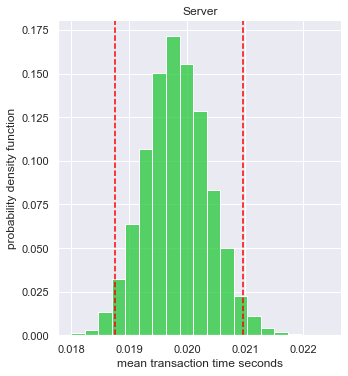

Server 95% доверительный интервал среднего в секундах: [0.01876494 0.02096506] 
Server  стандартная ошибка среднего эмпирических данных: 0.0005509482734900955 
Server  стандартная ошибка среднего смоделированного массива: 0.0005501202089232265 


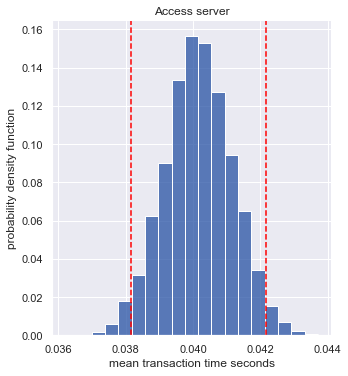

Access server 95% доверительный интервал среднего в секундах: [0.0381675  0.04218506] 
Access server  стандартная ошибка среднего эмпирических данных: 0.0010049121853226187 
Access server  стандартная ошибка среднего смоделированного массива: 0.0010092252827762415 


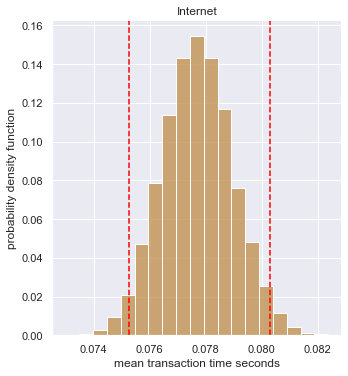

Internet 95% доверительный интервал среднего в секундах: [0.07526382 0.08028894] 
Internet  стандартная ошибка среднего эмпирических данных: 0.001273045442912571 
Internet  стандартная ошибка среднего смоделированного массива: 0.0012616599949135394 


In [17]:
f_plot(data=serv_seconds,repl_data=serv_bs_replicates,label='Server')
f_plot(data=as_seconds,repl_data=as_bs_replicates,label='Access server')
f_plot(data=int_seconds,repl_data=int_bs_replicates,label='Internet')

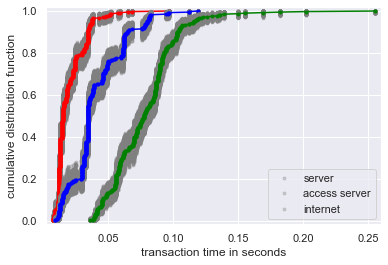

In [18]:

for i in range(1000):
    bs_sample=np.random.choice(df_server.seconds,len(df_server.seconds))
    x,y=ecdf(bs_sample)
    _=plt.plot(x,y,marker='.',linestyle='none',color='grey',alpha=0.3)
_=plt.plot(x_s,y_s,marker='.',color='red')
_=plt.margins(0.02)
_=plt.xlabel('transaction time in seconds')
_=plt.ylabel('cumulative distribution function')
#plt.show()

for i in range(1000):
    bs_sample=np.random.choice(df_as.seconds,len(df_as.seconds))
    x,y=ecdf(bs_sample)
    _=plt.plot(x,y,marker='.',linestyle='none',color='grey',alpha=0.3)
_=plt.plot(x_as,y_as,marker='.',color='blue')
_=plt.margins(0.02)
_=plt.xlabel('transaction time in seconds')
_=plt.ylabel('cumulative distribution function')
#plt.show()
for i in range(1000):
    bs_sample=np.random.choice(df_internet.seconds,len(df_internet.seconds))
    x,y=ecdf(bs_sample)
    _=plt.plot(x,y,marker='.',linestyle='none',color='grey',alpha=0.3)
_=plt.plot(x_int,y_int,marker='.',color='green')
_=plt.margins(0.02)
_=plt.xlabel('transaction time in seconds')
_=plt.ylabel('cumulative distribution function')
_=plt.legend(('server','access server','internet'),loc='lower right')
#plt.show()